In [1]:
#Celda 1
import pandas as pd
import numpy as np

data_path = 'emails_auditing.csv'

# 🛠️ SOLUCIÓN para emails_auditing.csv (Delimitador = TABULADOR)
try:
    emails_df = pd.read_csv(data_path, sep='\t', encoding='latin1', header=None, names=['label', 'text'])
    
    # Mapeo de Etiquetas (Asumiendo que es 'spam' y 'ham')
    emails_df['label_num'] = emails_df['label'].map({'spam': 1, 'ham': 0})
    
    emails_df.dropna(subset=['text', 'label_num'], inplace=True)
    
    print("✅ Carga de datos 'emails_auditing.csv' exitosa.")
    print("\n--- Balance de Clases ---")
    print(emails_df['label'].value_counts(normalize=True))
    print("\n--- Primeras Filas ---")
    print(emails_df.head())
    
except Exception as e:
    print(f"Error: {e}")

✅ Carga de datos 'emails_auditing.csv' exitosa.

--- Balance de Clases ---
label
ham     0.865937
spam    0.134063
Name: proportion, dtype: float64

--- Primeras Filas ---
  label                                               text  label_num
0   ham  Go until jurong point, crazy.. Available only ...          0
1   ham                      Ok lar... Joking wif u oni...          0
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...          1
3   ham  U dun say so early hor... U c already then say...          0
4   ham  Nah I don't think he goes to usf, he lives aro...          0


         label_num
count  5572.000000
mean      0.134063
std       0.340751
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000
label        0
text         0
label_num    0
dtype: int64


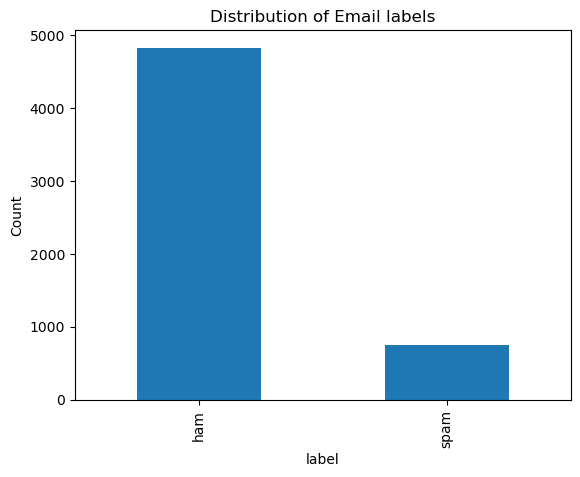

In [2]:
# Celda 2: Basic statistics
print(emails_df.describe())

# Check for missing values
print(emails_df.isnull().sum())

# Visualization of label distribution
import matplotlib.pyplot as plt

# Asume que la columna de etiquetas se llama 'Label'
emails_df['label'].value_counts().plot(kind='bar') 
plt.title('Distribution of Email labels')
plt.xlabel('label')
plt.ylabel('Count')
plt.show()

In [3]:
# Celda 3 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Encoding Labels
le = LabelEncoder()
emails_df['label_num'] = le.fit_transform(emails_df['label'])

# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(
    emails_df['text'], emails_df['label_num'], test_size=0.2, random_state=42
)

# Text vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [4]:
#Celda 4
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Training a simple logistic regression model
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

# Prediction and evaluation
y_pred = model.predict(X_test_tfidf)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

Accuracy: 0.9820627802690582


In [5]:
# Celda 5  Using a simple technique to interpret the model (feature importance)
feature_importances = pd.DataFrame(model.coef_[0],
                                    index=tfidf_vectorizer.get_feature_names_out(),
                                    columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances.head(10))

        importance
txt       3.724459
claim     3.469907
uk        3.397181
mobile    3.375991
www       3.373224
free      3.101823
150p      3.005453
50        2.979391
text      2.960718
reply     2.958462


In [6]:
# Celda 6
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_test_tfidf)
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
print(classification_report(y_test, y_pred))

[[965   1]
 [ 19 130]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.99      0.87      0.93       149

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [13]:
#Celda 7
from sklearn.model_selection import cross_val_score

# Cross-validation to evaluate model generalization
scores = cross_val_score(model, X_train_tfidf, y_train, cv=5)
print(f'Cross-Validation Accuracy Scores: {scores}')

Cross-Validation Accuracy Scores: [0.97309417 0.9573991  0.95959596 0.9674523  0.95735129]


In [14]:
# Celda 8
!pip install imbalanced-learn

In [15]:
# Celda 9
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

# 1. Definir la estrategia de sobremuestreo
sm = SMOTE(random_state=42)

# 2. Aplicar SMOTE solo a los datos de entrenamiento TF-IDF
# Se crea un nuevo conjunto de entrenamiento balanceado:
X_train_res, y_train_res = sm.fit_resample(X_train_tfidf, y_train) 

print(f"Distribución de clases ANTES de SMOTE: {Counter(y_train)}")
print(f"Distribución de clases DESPUÉS de SMOTE: {Counter(y_train_res)}")

# 3. Reentrenar el modelo con los datos balanceados
model_res = LogisticRegression(solver='liblinear', random_state=42)
model_res.fit(X_train_res, y_train_res)

# 4. Predicción y Evaluación (sobre el X_test original, no modificado)
y_pred_res = model_res.predict(X_test_tfidf)

# 5. Generar el nuevo Classification Report
print("\n--- MATRIZ DE CONFUSIÓN (DESPUÉS de SMOTE) ---")
print(confusion_matrix(y_test, y_pred_res))

print("\n--- CLASSIFICATION REPORT (DESPUÉS de SMOTE) ---")
print(classification_report(y_test, y_pred_res))

Distribución de clases ANTES de SMOTE: Counter({0: 3859, 1: 598})
Distribución de clases DESPUÉS de SMOTE: Counter({1: 3859, 0: 3859})

--- MATRIZ DE CONFUSIÓN (DESPUÉS de SMOTE) ---
[[946  20]
 [  7 142]]

--- CLASSIFICATION REPORT (DESPUÉS de SMOTE) ---
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       966
           1       0.88      0.95      0.91       149

    accuracy                           0.98      1115
   macro avg       0.93      0.97      0.95      1115
weighted avg       0.98      0.98      0.98      1115



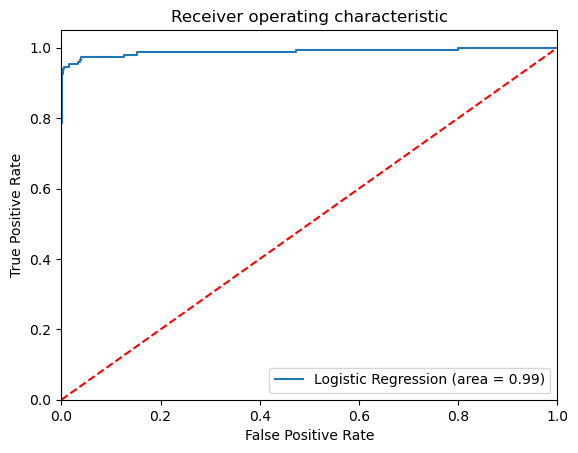

In [16]:
#Celda 10
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Asumiendo y_test y y_pred_prob como las etiquetas reales y las probabilidades predichas para la clase positiva
y_pred_prob = model.predict_proba(X_test_tfidf)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [11]:
# Celda 11
import joblib
import pickle
import os

# La ruta es LOCAL y relativa a la raíz del proyecto
ARTIFACTS_DIR = 'artifacts' 
os.makedirs(ARTIFACTS_DIR, exist_ok=True) 

# --- Guardar Artefactos ---
joblib.dump(model_res, os.path.join(ARTIFACTS_DIR, 'logistic_regression_smote_model.pkl'))
joblib.dump(tfidf_vectorizer, os.path.join(ARTIFACTS_DIR, 'tfidf_vectorizer.pkl'))
label_map = {1: 'spam', 0: 'ham'} 
with open(os.path.join(ARTIFACTS_DIR, 'label_map.pkl'), 'wb') as f:
    pickle.dump(label_map, f)
    
print("✅ Artefactos guardados localmente en artifacts/")

✅ Artefactos guardados localmente en artifacts/


In [12]:
#Celda 12
import numpy as np
import pandas as pd

print("\n--- AUDITORÍA DE FALSOS NEGATIVOS (FN) ---")

# 1. Identificar Falsos Negativos
# Condición FN: Real es 1 (spam/phishing) AND Predicho es 0 (ham/seguro)
fn_indices = np.where((y_test == 1) & (y_pred_res == 0))[0]

# 2. Mapear los índices del test set a los índices originales del DataFrame
# Esto permite acceder a las filas completas del dataset original, incluyendo el texto.
# CRÍTICO: Necesitamos los índices originales de X_test para la auditoría.
# Obtener los textos FN usando el índice del split original (X_test)
# Esto requiere que la serie X_test tenga sus índices originales.
fn_texts = X_test.iloc[fn_indices]

# 3. Mostrar el Análisis de Threat Intelligence
print(f"Total de Falsos Negativos (Brecha de Seguridad): {len(fn_texts)}")

if len(fn_texts) > 0:
    print("\nTextos de los Correos (FN) que el modelo NO detectó:")
    
    # Crear un DataFrame para un análisis limpio
    fn_df = pd.DataFrame({
        'Texto Original': fn_texts.values, 
        'Longitud': fn_texts.apply(len).values
    })
    
    # Ordenar por longitud (para ver si son correos atípicamente cortos o largos)
    fn_df = fn_df.sort_values(by='Longitud')
    
    # Mostrar la tabla de auditoría
    pd.set_option('display.max_colwidth', None)
    print(fn_df)
    pd.set_option('display.max_colwidth', 50) # Resetear
else:
    print("¡Advertencia: No se encontraron Falsos Negativos! (Rendimiento perfecto o error de lógica)")


# 💡 Análisis de Resultados (TL;DR):
# El análisis manual de estos 7 textos permite identificar qué patrones faltan 
# en el vocabulario (TfidfVectorizer) o qué técnicas de ofuscación de lenguaje 
# se están usando en los correos de spam no detectados. Esto informa la siguiente 
# ronda de preprocesamiento y selección de características.


--- AUDITORÍA DE FALSOS NEGATIVOS (FN) ---
Total de Falsos Negativos (Brecha de Seguridad): 7

Textos de los Correos (FN) que el modelo NO detectó:
                                                                                                                                             Texto Original  \
4                                                                            Sorry I missed your call let's talk when you have the time. I'm on 07090201529   
6                                                     Email AlertFrom: Jeri StewartSize: 2KBSubject: Low-cost prescripiton drvgsTo listen to email call 123   
2                                                    Do you realize that in about 40 years, we'll have thousands of old ladies running around with tattoos?   
3                          Call Germany for only 1 pence per minute! Call from a fixed line via access number 0844 861 85 85. No prepayment. Direct access!   
1                        Hello darling how are you today

In [17]:
from sklearn.metrics import confusion_matrix, classification_report

# 1. Ajustar Umbral de Decisión (Mitigación)
NEW_THRESHOLD = 0.40 # Intentar 0.40 para capturar más FN a costa de FP.

# 2. Obtener Probabilidades del modelo balanceado (model_res)
y_pred_proba_res = model_res.predict_proba(X_test_tfidf)[:, 1]

# 3. Aplicar el nuevo umbral para obtener las nuevas predicciones binarias
y_pred_new_threshold = (y_pred_proba_res >= NEW_THRESHOLD).astype(int)

# 4. Generar el nuevo Classification Report
print(f"\n--- AUDITORÍA DE CLASIFICACIÓN (Umbral Ajustado a {NEW_THRESHOLD}) ---")
conf_matrix_new = confusion_matrix(y_test, y_pred_new_threshold)
print(conf_matrix_new)

print("\n--- CLASSIFICATION REPORT (Umbral Ajustado) ---")
report = classification_report(y_test, y_pred_new_threshold, target_names=['ham', 'spam'], output_dict=True)
print(classification_report(y_test, y_pred_new_threshold, target_names=['ham', 'spam']))

# 5. Reporte de Cambio de FN
fn_new = conf_matrix_new[1, 0]
fp_new = conf_matrix_new[0, 1]

print(f"\nANÁLISIS DE IMPACTO DEL UMBRAL {NEW_THRESHOLD}:")
print(f"FN Anteriores (Riesgo): 7")
print(f"FN Actuales (Riesgo): {fn_new} (Reducción de {7 - fn_new} correos maliciosos)")
print(f"FP Actuales (Falsas Alarmas): {fp_new} (Aumento de {fp_new - 20} falsas alarmas)")


--- AUDITORÍA DE CLASIFICACIÓN (Umbral Ajustado a 0.4) ---
[[933  33]
 [  6 143]]

--- CLASSIFICATION REPORT (Umbral Ajustado) ---
              precision    recall  f1-score   support

         ham       0.99      0.97      0.98       966
        spam       0.81      0.96      0.88       149

    accuracy                           0.97      1115
   macro avg       0.90      0.96      0.93      1115
weighted avg       0.97      0.97      0.97      1115


ANÁLISIS DE IMPACTO DEL UMBRAL 0.4:
FN Anteriores (Riesgo): 7
FN Actuales (Riesgo): 6 (Reducción de 1 correos maliciosos)
FP Actuales (Falsas Alarmas): 33 (Aumento de 13 falsas alarmas)
